In [ ]:
import random
import time
import pandas as pd
import numpy as np
import re
import torch
import string

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from tensorflow. keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from torch.optim.optimizer import Optimizer

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

root_path = "/content/drive/MyDrive/softcom project"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Parameters

In [ ]:
embed_size = 300 # how big is each word vector
max_features = 100000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 70 # max number of words in a question to use

# 1. Dataset

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/softcom project/Dataset/text_emotions.csv")
data.head()

,content,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## 1.1 Finding the Length

In [ ]:
data['length'] = data['content'].apply(lambda x: len(str(x).split()))
data

,content,sentiment,length
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,21
2,im grabbing a minute to post i feel greedy wrong,anger,10
3,i am ever feeling nostalgic about the fireplac...,love,18
4,i am feeling grouchy,anger,4
...,...,...,...
19995,im having ssa examination tomorrow in the morn...,sadness,34
19996,i constantly worry about their fight against n...,joy,29
19997,i feel its important to share this info for th...,joy,15
19998,i truly feel that if you are passionate enough...,joy,19


## 1.2 Text Preprocessing

In [ ]:
data['sentiment'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [ ]:
import os
import pandas as pd
import re
import string

# Your root path
root_path = "/content/drive/MyDrive/softcom project"

# The specific path to the emojis.txt file
emojis_path = "/content/drive/MyDrive/softcom project/Dataset/emojis.txt"

# Read the CSV file into a DataFrame
emojis = pd.read_csv(emojis_path, sep=',', header=None)
emojis_dict = {i: j for i, j in zip(emojis[0], emojis[1])}
pattern = '|'.join(sorted(re.escape(k) for k in emojis_dict))

def replace_emojis(text):
    text = re.sub(pattern, lambda m: emojis_dict.get(m.group(0)), text, flags=re.IGNORECASE)
    return text

def remove_punct(text):
    text = replace_emojis(text)
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

contraction_dict = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
                    "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
                    "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would",
                    "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                    "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
                    "I'm": "I am", "im": "i am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
                    "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not",
                    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
                    "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
                    "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                    "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would", "that'd've": "that would have",
                    "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is",
                    "here's": "here is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                    "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                    "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
                    "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                    "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
                    "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have",
                    "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

# Usage
replace_contractions("i didn't feel humiliated")

def text_preprocessing(text):
    text = replace_contractions(text)
    text = remove_punct(text)
    text = clean_text(text)
    text = text.lower()
    return text


## 1.3 Train Test Split
  Train Size = 80%

  Test Size = 20%

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['content'], data['sentiment'],
                                                    stratify=data['sentiment'],
                                                    test_size=0.2)

In [ ]:
print("Train shape : ",X_train.shape)
print("Test shape : ",X_test.shape)

Train shape :  (16000,)
Test shape :  (4000,)


## 1.4 Padding Dataset
  Maximum Length = 70

In [ ]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
train_X = tokenizer.texts_to_sequences(X_train)
test_X = tokenizer.texts_to_sequences(X_test)

## Pad the sentences
train_X = pad_sequences(train_X, maxlen=maxlen, truncating='post', padding='post')
test_X = pad_sequences(test_X, maxlen=maxlen, truncating='post', padding='post')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(y_train.values)
test_y = le.transform(y_test.values)
le.classes_

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
!pip install transformers requests beautifulsoup4 pandas numpy

# 2. Word Emebedding (Glove.6B.300d)

## 2.1 Load Embeddings


In [ ]:
def load_glove(word_index):
    EMBEDDING_FILE = "/content/drive/MyDrive/softcom project/Dataset/glove.6B.300d.txt"

    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')[:300]

    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = -0.005838499, 0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index) + 1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    return embedding_matrix

embedding_matrix = load_glove(tokenizer.word_index)
print('Shape of word embedding:', np.shape(embedding_matrix))


Shape of word embedding: (15191, 300)


In [ ]:
!pip install torch --upgrade
!pip install transformers --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 29.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assuming y_train is your label data
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(y_train_encoded, dtype=torch.long)


In [ ]:
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder

# Assuming y_train is your label data as a Pandas Series
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Convert labels to PyTorch tensor
train_labels = torch.tensor(y_train_encoded, dtype=torch.long)


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Set device (cuda if available, else cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))
model.to(device)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
train_labels = torch.tensor(y_train_encoded, dtype=torch.long)
test_labels = torch.tensor(le.transform(y_test), dtype=torch.long)

# Tokenize and pad sequences
train_inputs = tokenizer(X_train.tolist(), max_length=maxlen, padding='max_length', truncation=True, return_tensors="pt")
test_inputs = tokenizer(X_test.tolist(), max_length=maxlen, padding='max_length', truncation=True, return_tensors="pt")

# Convert labels to PyTorch tensors
train_labels = torch.tensor(y_train_encoded, dtype=torch.long).to(device)
test_labels = torch.tensor(le.transform(y_test), dtype=torch.long).to(device)

# Create DataLoader with fixed batch size
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)  # Fixed EVAL_BATCH_SIZE

# Set optimizer and scheduler with fixed learning rate
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3)

# Training loop with fixed epochs
epochs = 3
for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

# Evaluation with fixed EVAL_BATCH_SIZE
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())

# Print classification report
print("Classification Report:\n", classification_report(le.transform(y_test), predictions, target_names=le.classes_))



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
               precision    recall  f1-score   support

       anger       0.94      0.91      0.93       542
        fear       0.88      0.92      0.90       475
         joy       0.96      0.95      0.96      1352
        love       0.87      0.86      0.87       328
     sadness       0.97      0.97      0.97      1159
    surprise       0.77      0.83      0.80       144

    accuracy                           0.94      4000
   macro avg       0.90      0.91      0.90      4000
weighted avg       0.94      0.94      0.94      4000



In [ ]:
input_string = input('Input Text: ')

# Tokenize and pad the input string
input_tokens = tokenizer(input_string, max_length=maxlen, padding='max_length', truncation=True, return_tensors="pt")

# Convert the input to the appropriate device
input_ids = input_tokens['input_ids'].to(device)
attention_mask = input_tokens['attention_mask'].to(device)

# Make prediction using the trained BERT model
model.eval()
with torch.no_grad():
    output = model(input_ids, attention_mask=attention_mask)
    logits = output.logits
    prediction = torch.argmax(logits, dim=1).cpu().item()

# Convert the numerical prediction back to the original label
predicted_emotion = le.inverse_transform([prediction])[0]

print('Emotion using BERT:', predicted_emotion)

In [ ]:
!pip install transformers


In [ ]:
n_epochs =30
filter_sizes = [2,3,5]
num_filters = 32
n_classes = len(le.classes_)
batch_size = 512

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, n_classes):
        super(BiLSTM, self).__init__()
        n_classes = len(le.classes_)
        self.hidden_size = 64
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, num_layers=1, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size * 4, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(32, n_classes)

    def forward(self, x, attention_mask=None):
        h_embedding = self.embedding(x)
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out


In [ ]:
model = BiLSTM(n_classes).to(device)
loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Load train and test in CUDA or CPU Memory
x_train = torch.tensor(train_X, dtype=torch.long).to(device)
y_train = torch.tensor(train_y, dtype=torch.long).to(device)
x_cv = torch.tensor(test_X, dtype=torch.long).to(device)
y_cv = torch.tensor(test_y, dtype=torch.long).to(device)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []
train_acc_list, test_acc_list, prec_list, recall_list, f1_list = [],[],[],[],[]

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.
    train_preds = np.zeros((len(x_train),len(le.classes_)))
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).detach().cpu().numpy()
        avg_loss += loss.item() / len(train_loader)


    y_pred_train = train_preds.argmax(axis=1)
    train_accuracy = round(accuracy_score(y_pred_train,train_y)*100,3)

    # Set model to validation configuration -Doesn't get trained here
    model.eval()
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))

    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()

    # Check Accuracy
    y_pred = val_preds.argmax(axis=1)
    test_accuracy = round(accuracy_score(y_pred,test_y)*100,3)
    test_precision = round(precision_score(y_pred,test_y, average='weighted')*100,3)
    test_recall = round(np.mean(recall_score(y_pred, test_y, average='weighted'))*100,3)
    test_f1_score = round(f1_score(y_pred, test_y, average='weighted')*100,3)


    # storing accuracy,precision,recall,f1 score data into list
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    train_acc_list.append(train_accuracy)
    test_acc_list.append(test_accuracy)
    prec_list.append(test_precision)
    recall_list.append(test_recall)
    f1_list.append(test_f1_score)
    elapsed_time = time.time() - start_time
    print('Epoch {}/{}  Train loss={:.3f}   Test loss={:.3f}   Train Accuracy={:.3f}   Test Accuracy={:.3f}   Precision={:.3f}   Recall={:.3f}   F1 Score={:.3f}   time={:.2f} s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, train_accuracy, test_accuracy, test_precision, test_recall, test_f1_score, elapsed_time))

Epoch 1/30  Train loss=1.632   Test loss=1.567   Train Accuracy=30.769   Test Accuracy=33.800   Precision=100.000   Recall=33.800   F1 Score=50.523   time=1.23 s
Epoch 2/30  Train loss=1.539   Test loss=1.441   Train Accuracy=39.950   Test Accuracy=52.100   Precision=82.618   Recall=52.100   F1 Score=63.836   time=0.70 s
Epoch 3/30  Train loss=1.281   Test loss=1.124   Train Accuracy=53.431   Test Accuracy=55.800   Precision=88.792   Recall=55.800   F1 Score=67.921   time=0.69 s
Epoch 4/30  Train loss=1.046   Test loss=0.918   Train Accuracy=60.550   Test Accuracy=65.625   Precision=89.248   Recall=65.625   F1 Score=74.341   time=0.69 s
Epoch 5/30  Train loss=0.839   Test loss=0.703   Train Accuracy=69.794   Test Accuracy=74.850   Precision=88.929   Recall=74.850   F1 Score=80.407   time=0.68 s
Epoch 6/30  Train loss=0.646   Test loss=0.528   Train Accuracy=77.225   Test Accuracy=82.075   Precision=89.045   Recall=82.075   F1 Score=84.772   time=0.69 s
Epoch 7/30  Train loss=0.493   Te

# 3. Convolutional Neural Network (CNN)

In [ ]:
class CNN(nn.Module):

    def __init__(self,num_filters,filter_sizes,n_classes):
        super(CNN, self).__init__()

        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.fc1(x)
        return logit

## 3.1 Setting Hyperparameters

## 3.2 Model Evaluation

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_cnn = CNN(num_filters,filter_sizes,n_classes).to(device)
loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_cnn.parameters()), lr=0.001)

# Load train and test in CUDA or CPU Memory
x_train = torch.tensor(train_X, dtype=torch.long).to(device)
y_train = torch.tensor(train_y, dtype=torch.long).to(device)
x_cv = torch.tensor(test_X, dtype=torch.long).to(device)
y_cv = torch.tensor(test_y, dtype=torch.long).to(device)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

cnn_train_loss = []
cnn_valid_loss = []
cnn_train_acc_list, cnn_test_acc_list, cnn_prec_list, cnn_recall_list, cnn_f1_list = [],[],[],[],[]

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model_cnn.train()
    avg_loss = 0.
    train_preds = np.zeros((len(x_train),len(le.classes_)))
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model_cnn(x_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).detach().cpu().numpy()
        avg_loss += loss.item() / len(train_loader)


    y_pred_train = train_preds.argmax(axis=1)
    train_accuracy = round(accuracy_score(y_pred_train,train_y)*100,3)

    # Set model to validation configuration -Doesn't get trained here
    model_cnn.eval()
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))

    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model_cnn(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()

    # Determining Accuracy, Precision, Recall, F1 Score
    y_pred = val_preds.argmax(axis=1)
    test_accuracy = round(accuracy_score(y_pred,test_y)*100,3)
    test_precision = round(precision_score(y_pred,test_y, average='weighted')*100,3)
    test_recall = round(np.mean(recall_score(y_pred, test_y, average='weighted'))*100,3)
    test_f1_score = round(f1_score(y_pred, test_y, average='weighted')*100,3)


    # storing accuracy,precision,recall,f1 score data into list
    cnn_train_loss.append(avg_loss)
    cnn_valid_loss.append(avg_val_loss)
    cnn_train_acc_list.append(train_accuracy)
    cnn_test_acc_list.append(test_accuracy)
    cnn_prec_list.append(test_precision)
    cnn_recall_list.append(test_recall)
    cnn_f1_list.append(test_f1_score)
    elapsed_time = time.time() - start_time
    print('Epoch {}/{}  Train loss={:.3f}   Test loss={:.3f}   Train Accuracy={:.3f}   Test Accuracy={:.3f}   Precision={:.3f}   Recall={:.3f}   F1 Score={:.3f}   time={:.2f} s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, train_accuracy, test_accuracy, test_precision, test_recall, test_f1_score, elapsed_time))

Epoch 1/30  Train loss=1.472   Test loss=1.259   Train Accuracy=44.862   Test Accuracy=54.950   Precision=86.538   Recall=54.950   F1 Score=66.970   time=0.50 s
Epoch 2/30  Train loss=1.053   Test loss=0.873   Train Accuracy=64.038   Test Accuracy=68.975   Precision=84.566   Recall=68.975   F1 Score=74.067   time=0.51 s
Epoch 3/30  Train loss=0.744   Test loss=0.646   Train Accuracy=74.662   Test Accuracy=77.000   Precision=83.130   Recall=77.000   F1 Score=78.634   time=0.51 s
Epoch 4/30  Train loss=0.559   Test loss=0.506   Train Accuracy=81.262   Test Accuracy=81.975   Precision=84.070   Recall=81.975   F1 Score=82.529   time=0.52 s
Epoch 5/30  Train loss=0.451   Test loss=0.427   Train Accuracy=84.662   Test Accuracy=84.825   Precision=85.922   Recall=84.825   F1 Score=85.109   time=0.54 s
Epoch 6/30  Train loss=0.376   Test loss=0.379   Train Accuracy=87.431   Test Accuracy=86.150   Precision=86.989   Recall=86.150   F1 Score=86.356   time=0.60 s
Epoch 7/30  Train loss=0.324   Tes

In [ ]:
from sklearn.metrics import classification_report

# Set the model to evaluation mode
model.eval()

# Make predictions on the test set
with torch.no_grad():
    test_preds = model(torch.tensor(test_X, dtype=torch.long).to(device))

# Convert the predictions to class labels
predicted_labels = torch.argmax(test_preds, axis=1).cpu().numpy()

# Print the classification report
print("BiLSTM Classification Report:\n", classification_report(test_y, predicted_labels, target_names=le.classes_))


BiLSTM Classification Report:
               precision    recall  f1-score   support

       anger       0.91      0.94      0.92       542
        fear       0.92      0.85      0.88       475
         joy       0.95      0.93      0.94      1352
        love       0.86      0.87      0.86       328
     sadness       0.94      0.97      0.95      1159
    surprise       0.75      0.81      0.78       144

    accuracy                           0.92      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.92      0.92      0.92      4000



In [ ]:
from sklearn.metrics import classification_report

# Set the model to evaluation mode
model_cnn.eval()

# Make predictions on the test set
with torch.no_grad():
    test_preds_cnn = model_cnn(torch.tensor(test_X, dtype=torch.long).to(device))

# Convert the predictions to class labels
predicted_labels_cnn = torch.argmax(test_preds_cnn, axis=1).cpu().numpy()

# Print the classification report
print("CNN Classification Report:\n", classification_report(test_y, predicted_labels_cnn, target_names=le.classes_))


CNN Classification Report:
               precision    recall  f1-score   support

       anger       0.91      0.91      0.91       542
        fear       0.86      0.88      0.87       475
         joy       0.92      0.92      0.92      1352
        love       0.80      0.84      0.82       328
     sadness       0.94      0.92      0.93      1159
    surprise       0.77      0.73      0.75       144

    accuracy                           0.90      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.90      0.90      0.90      4000



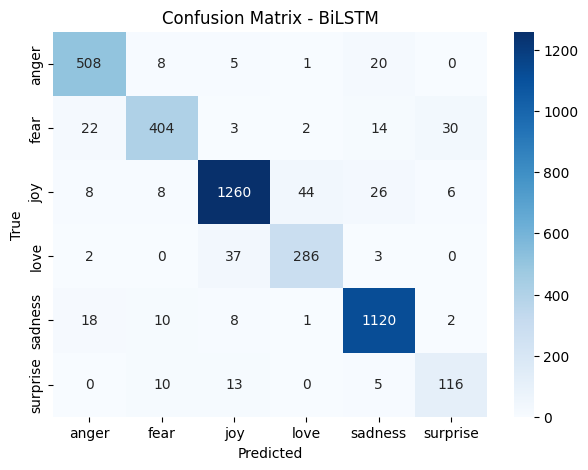

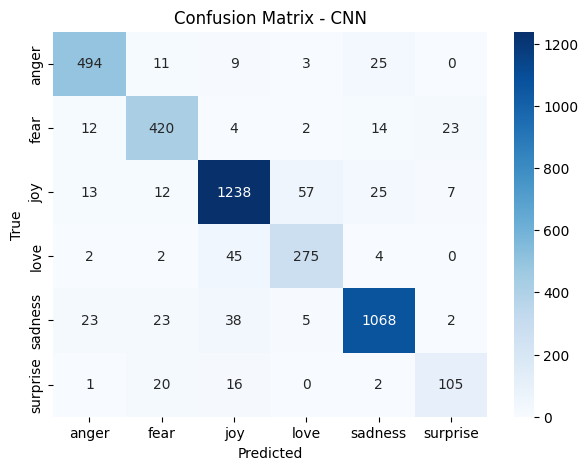

In [ ]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# BiLSTM Confusion Matrix
plot_confusion_matrix(test_y, predicted_labels, le.classes_, 'BiLSTM')

# CNN Confusion Matrix
plot_confusion_matrix(test_y, predicted_labels_cnn, le.classes_, 'CNN')


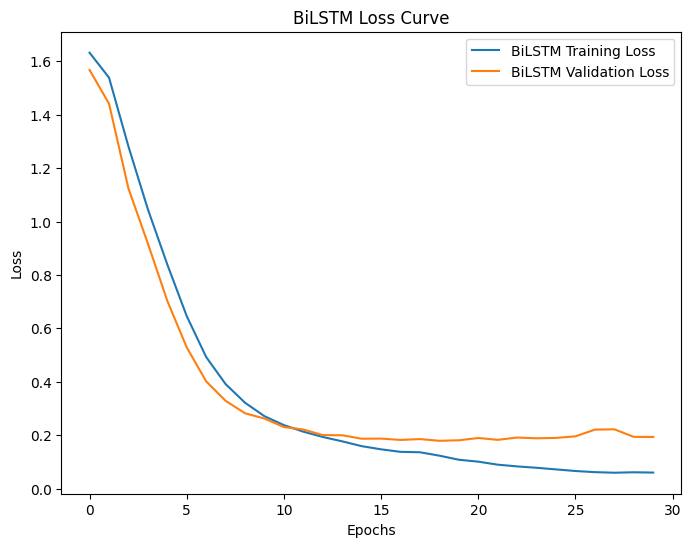

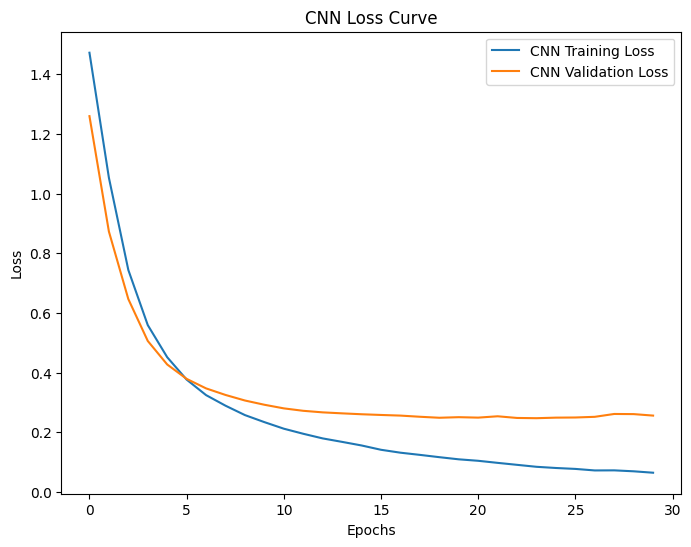

In [ ]:
# BiLSTM Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='BiLSTM Training Loss')
plt.plot(valid_loss, label='BiLSTM Validation Loss')
plt.title('BiLSTM Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# CNN Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(cnn_train_loss, label='CNN Training Loss')
plt.plot(cnn_valid_loss, label='CNN Validation Loss')
plt.title('CNN Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


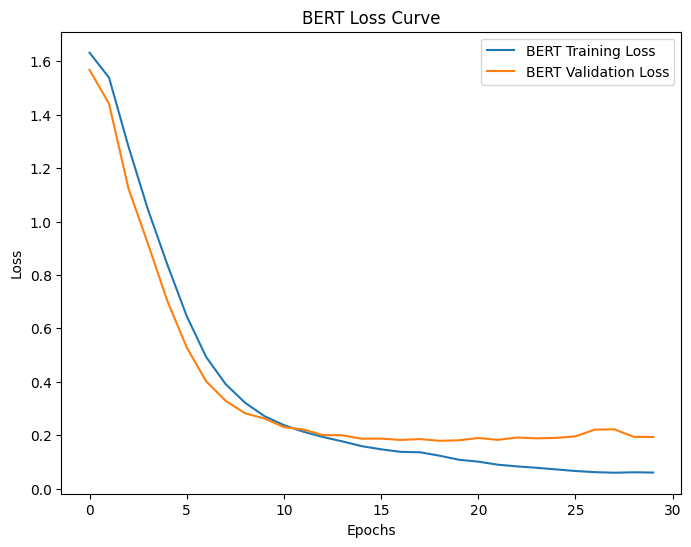

In [ ]:
# Assuming you have already trained the BERT model and collected the training loss and validation loss

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='BERT Training Loss')
plt.plot(valid_loss, label='BERT Validation Loss')
plt.title('BERT Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
def predict_single(x):
    x = text_preprocessing(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).to(device)

    pred_cnn = model_cnn(x).detach()
    pred_cnn = F.softmax(pred_cnn).cpu().numpy()
    pred_cnn = pred_cnn.argmax(axis=1)
    pred_cnn = le.classes_[pred_cnn]

    pred_bilstm = model(x).detach()
    pred_bilstm = F.softmax(pred_bilstm).cpu().numpy()
    pred_bilstm = pred_bilstm.argmax(axis=1)
    pred_bilstm = le.classes_[pred_bilstm]
    return pred_cnn[0],pred_bilstm[0]
input_string = input('Input Text: ')
cnn_pred, bilstm_pred = predict_single(input_string)
print('Emotion using CNN:',cnn_pred)
print('Emotion using BiLSTM:',bilstm_pred)

Input Text: i feel like a miserable piece of garbage
Emotion using CNN: sadness
Emotion using BiLSTM: sadness
